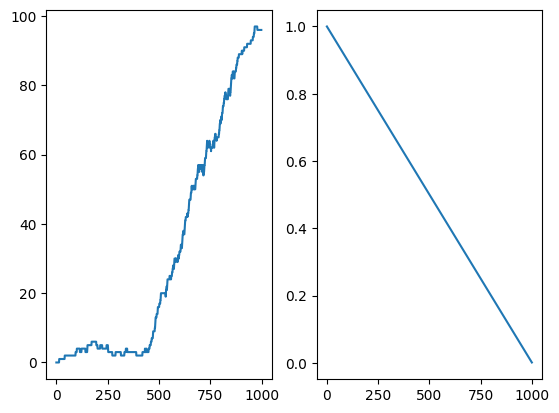

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from collections import deque
import random
import numpy as np
import matplotlib.pyplot as plt

class DQN(nn.Module):
    def __init__(self,input_size, output_size, hidden_layers):
        super().__init__()

        layers = []
        previous_size = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(previous_size, hidden_size))
            layers.append(nn.ReLU())
            previous_size = hidden_size

        layers.append(nn.Linear(previous_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
class ReplayMemory():
    def __init__(self, max_size):
        self.memory = deque(maxlen=max_size)

    def addData(self, dataPoint):
        self.memory.append(dataPoint)

    def sample(self, batch_size):
        return random.sample(population=self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)
    
def optimize(optimizer, loss_function, discount_factor, numStates, train_data, policyDQN, targetDQN):
    states, actions, next_states, rewards, dones = zip(*train_data)

    # Convert state to one hot encoding
    state_batch = torch.zeros(len(states), numStates)
    next_state_batch = torch.zeros(len(next_states), numStates)
    for i, (s, ns) in enumerate(zip(states, next_states)):
        state_batch[i][s] = 1
        next_state_batch[i][ns] = 1

    actions = torch.tensor(actions, dtype=torch.long)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    current_q = policyDQN(state_batch)

    with torch.no_grad():
        next_q = targetDQN(next_state_batch).max(1)[0]
        target_values = rewards + discount_factor * next_q * (1 - dones)

    current_q_selected = current_q[torch.arange(len(states)), actions]

    loss = loss_function(current_q_selected, target_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def stateToDQNInput(state, num_states):
    state_tensor = torch.zeros(num_states)
    state_tensor[state] = 1
    return state_tensor.unsqueeze(0)

def generateEpisode(env, epsilon, numStates, policyDQN):
    state, _ = env.reset()
    terminated = False
    truncatd = False

    dataList = []
    sumOfRewards = 0
    while (not terminated) and (not truncatd):
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = stateToDQNInput(state, numStates)
                q_values = policyDQN(state_tensor)
                action = torch.argmax(q_values).item()

        next_state, reward, terminated, truncatd, _ = env.step(action)
        dataList.append((state, action, next_state, reward, terminated))
        sumOfRewards += reward
        state = next_state

    return dataList, sumOfRewards

def deepQLearning(epsInit, numEpisodes, stepsToSync, discountFactor, learningRate, minibatchSize):
    env = gym.make('FrozenLake-v1', is_slippery=False, map_name='4x4')
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    policyDQN = DQN(input_size=num_states, output_size=num_actions, hidden_layers=[num_states])
    targetDQN = DQN(input_size=num_states, output_size=num_actions, hidden_layers=[num_states])
    targetDQN.load_state_dict(policyDQN.state_dict())

    replayMemory = ReplayMemory(max_size=1000)

    epsilon = epsInit

    optimizer = optim.Adam(policyDQN.parameters(), lr=learningRate)
    lossFunction = nn.MSELoss()

    epsilonHistory = []
    rewards_per_episode = np.zeros(numEpisodes)
    step_count = 0
    for episode in range(numEpisodes):
        dataList, sumOfRewards = generateEpisode(env, epsilon, num_states, policyDQN)
        for data in dataList:
            replayMemory.addData(data)

        step_count += len(dataList)

        rewards_per_episode[episode] = sumOfRewards
        epsilonHistory.append(epsilon)

        if len(replayMemory) >= minibatchSize:
            minibatch = replayMemory.sample(minibatchSize)
            optimize(optimizer, lossFunction, discountFactor, num_states, minibatch, policyDQN, targetDQN)

            if step_count >= stepsToSync:
                targetDQN.load_state_dict(policyDQN.state_dict())
                step_count = 0

        epsilon = max(0, epsilon - (1 / numEpisodes))

    env.close()

    plt.figure(1)

    sum_rewards = np.zeros(numEpisodes)
    for x in range(numEpisodes):
        sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
    plt.subplot(121)
    plt.plot(sum_rewards)

    plt.subplot(122)
    plt.plot(epsilonHistory)

    plt.show()

    return policyDQN

if __name__ == "__main__":
    policyDQN = deepQLearning(epsInit=1., numEpisodes=1000, stepsToSync=10, discountFactor=0.9, learningRate=0.001, minibatchSize=32)